In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

functions define

In [2]:
def get_data_dict(data):
    data_dict = {}
    for m in range(12):
        row = m*18*20
        temp = data.iloc[row:row+18]
        for d in range(1,20):
            row += 18
            temp = pd.concat([temp,data.iloc[row:row+18]],axis=1)
        temp.set_axis(range(24*20),axis=1,inplace=True)
        data_dict[m] = temp
    return data_dict

def getMonthTrainData(month,hours,features):
    label = month.loc['PM2.5',hours:]
    X = np.empty((480-hours,len(features)*hours))
    for i in range(480-hours):
        X[i,:] = month.loc[features,i:i+hours-1].values.flatten()
    return X,label.values.astype(np.float)

def getYearTrainData(dict,hours,features):
    X,y = getMonthTrainData(dict[0],hours,features)
    for m in range(1,12):
        temp_X,temp_y = getMonthTrainData(dict[m],hours,features)
        X = np.concatenate((X,temp_X),axis=0)
        y = np.concatenate((y,temp_y),axis=0)
    return X,y.reshape(y.shape[0],-1)

def normal(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    return (X-mu)/sigma,mu,sigma

def loss_fun(theta,X,y,lbd=0):
    m = y.shape[0]
    theta_1 = theta.copy()
    theta_1[0] = 0
    X = np.concatenate((np.ones((m,1),dtype=np.float),X),axis=1)
    y_pred = X@theta
    temp = y_pred - y
    loss = temp.T@temp/m/2 + lbd/2/m*theta_1.T@theta_1
    grad = X.T@temp/m + lbd/m*theta_1
    return loss.item(),grad

def gradDecent(init_theta,X_train,y_train,X_test=[],y_test=[],lr=0.01,iteration=1000,lbd=0):
    theta = init_theta.copy()
    loss,grad = loss_fun(theta,X_train,y_train,lbd=lbd)
    
    if len(X_test)!=0:
        loss_val,_ = loss_fun(theta,X_test,y_test,lbd=0)
    loss_history = []
    loss_val_history = []
    sum_grad_sqrt = 0
    for i in range(iteration):
        loss_history.append(loss)
        if len(X_test)!=0:
            loss_val_history.append(loss_val)
        sum_grad_sqrt += grad**2
        theta = theta - lr*grad/np.sqrt(sum_grad_sqrt)
        loss,grad = loss_fun(theta,X_train,y_train,lbd=lbd)
        if len(X_test)!=0:
            loss_val,_ = loss_fun(theta,X_test,y_test,lbd=0)
    return theta,loss_history,loss_val_history

读取训练数据

In [3]:
data = pd.read_csv('train.csv',engine='python')

data.columns = ['Date', 'Place', 'Test', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
       '21', '22', '23']

data.drop(['Date','Place'],axis='columns',inplace=True)

data.set_index('Test',inplace=True)

data[data=='NR'] = 0

data_dict = get_data_dict(data)

In [4]:
hours = 9
features = ['AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10',
       'PM2.5', 'RAINFALL', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC',
       'WIND_SPEED', 'WS_HR']

In [5]:
X,y = getYearTrainData(data_dict,hours,features)

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train_norm,mu,sigma = normal(X_train)

X_test_norm = (X_test-mu)/sigma

m,n = X_train_norm.shape
init_theta = np.zeros((n+1,1))
lr = 0.3
iteration = 10000

In [6]:
theta,loss_history,loss_val_history = gradDecent(init_theta,X_train_norm,y_train,X_test_norm,y_test,lr,iteration)
last_loss,_ = loss_fun(theta,X_train_norm,y_train)
last_loss_val,_ = loss_fun(theta,X_test_norm,y_test)

last_loss,last_loss_val

(14.824665080137198, 19.828942672667193)

在利用前9个小时的全部features时，出现了overfitting

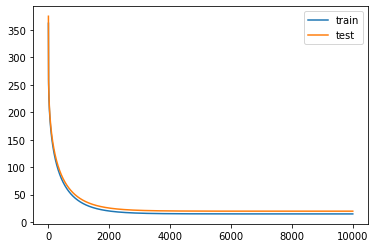

In [7]:
plt.plot(range(iteration),loss_history,range(iteration),loss_val_history)
plt.legend(['train','test'])

现在改用前5个小时的features

In [8]:
hours = 5

In [9]:
X,y = getYearTrainData(data_dict,hours,features)

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train_norm,mu,sigma = normal(X_train)

X_test_norm = (X_test-mu)/sigma

In [11]:
m,n = X_train_norm.shape
init_theta = np.zeros((n+1,1))
lr = 0.3
iteration = 10000

In [12]:
theta,loss_history,loss_val_history = gradDecent(init_theta,X_train_norm,y_train,X_test_norm,y_test,lr,iteration)
last_loss,_ = loss_fun(theta,X_train_norm,y_train)
last_loss_val,_ = loss_fun(theta,X_test_norm,y_test)

last_loss,last_loss_val

(16.755548292687042, 17.51514105534906)

validation set上表现要优于用前9个小时，但是否时因为overfitting呢？

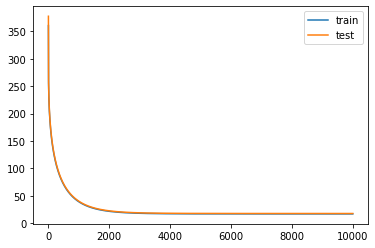

In [13]:
plt.plot(range(iteration),loss_history,range(iteration),loss_val_history)
plt.legend(['train','test'])

如果我只用PM2.5一个特征呢？

In [14]:
hours = 9
features = ['PM2.5']

In [15]:
X,y = getYearTrainData(data_dict,hours,features)

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train_norm,mu,sigma = normal(X_train)

X_test_norm = (X_test-mu)/sigma

In [16]:
m,n = X_train_norm.shape
init_theta = np.zeros((n+1,1))
lr = 0.3
iteration = 10000

In [17]:
theta,loss_history,loss_val_history = gradDecent(init_theta,X_train_norm,y_train,X_test_norm,y_test,lr,iteration)
last_loss,_ = loss_fun(theta,X_train_norm,y_train)
last_loss_val,_ = loss_fun(theta,X_test_norm,y_test)

last_loss,last_loss_val

(17.863090542350836, 20.755032133565358)

可以看到无论是train set还是validation set上，表现都不好。应该是underfitting。

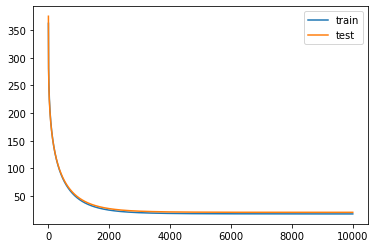

In [18]:
plt.plot(range(iteration),loss_history,range(iteration),loss_val_history)
plt.legend(['train','test'])

那我加入正则化看看

In [37]:
hours = 9
features = ['AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10',
       'PM2.5', 'RAINFALL', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC',
       'WIND_SPEED', 'WS_HR']
lbd = 10

In [38]:
X,y = getYearTrainData(data_dict,hours,features)

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train_norm,mu,sigma = normal(X_train)

X_test_norm = (X_test-mu)/sigma

m,n = X_train_norm.shape
init_theta = np.zeros((n+1,1))
lr = 0.3
iteration = 10000

In [39]:
theta,loss_history,loss_val_history = gradDecent(init_theta,X_train_norm,y_train,
                                                 X_test_norm,y_test,lr,iteration,lbd=lbd)
last_loss,_ = loss_fun(theta,X_train_norm,y_train)
last_loss_val,_ = loss_fun(theta,X_test_norm,y_test)

last_loss,last_loss_val

(14.870980931872566, 19.86156646521032)

在利用前9个小时的全部features时，出现了overfitting

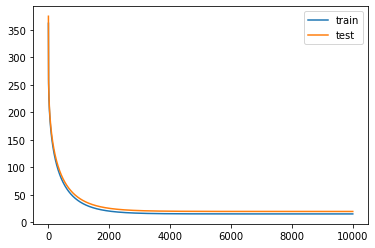

In [40]:
plt.plot(range(iteration),loss_history,range(iteration),loss_val_history)
plt.legend(['train','test'])

就算是通过正则化，也没能在9小时所有features的选择下获取更好的性能。我选择用5个小时参数来作预测。

In [42]:
hours = 5
features = ['AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10',
       'PM2.5', 'RAINFALL', 'RH', 'SO2', 'THC', 'WD_HR', 'WIND_DIREC',
       'WIND_SPEED', 'WS_HR']

In [43]:
X,y = getYearTrainData(data_dict,hours,features)

X_train_norm,mu,sigma = normal(X)
y_train = y

In [44]:
m,n = X_train_norm.shape
init_theta = np.zeros((n+1,1))
lr = 0.3
iteration = 10000

In [45]:
theta,loss_history,loss_val_history = gradDecent(init_theta,X_train_norm,y_train,X_test=[],y_test=[],lr=lr,iteration=iteration)
last_loss,_ = loss_fun(theta,X_train_norm,y_train)

last_loss

16.856309612126935

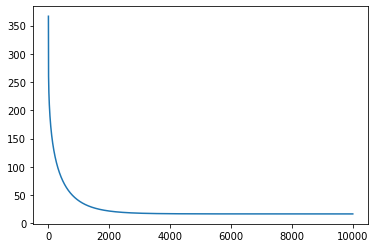

In [46]:
plt.plot(range(iteration),loss_history)

In [47]:
np.save('theta.npy',theta)

np.save('mu.npy',mu)

np.save('sigma.npy',sigma)